In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
testDf = pd.read_csv('test.csv', index_col=0)
trainDf = pd.read_csv('train.csv', index_col=0)

In [3]:
trainDf.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


/Users/garrickbercero/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/garrickbercero/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


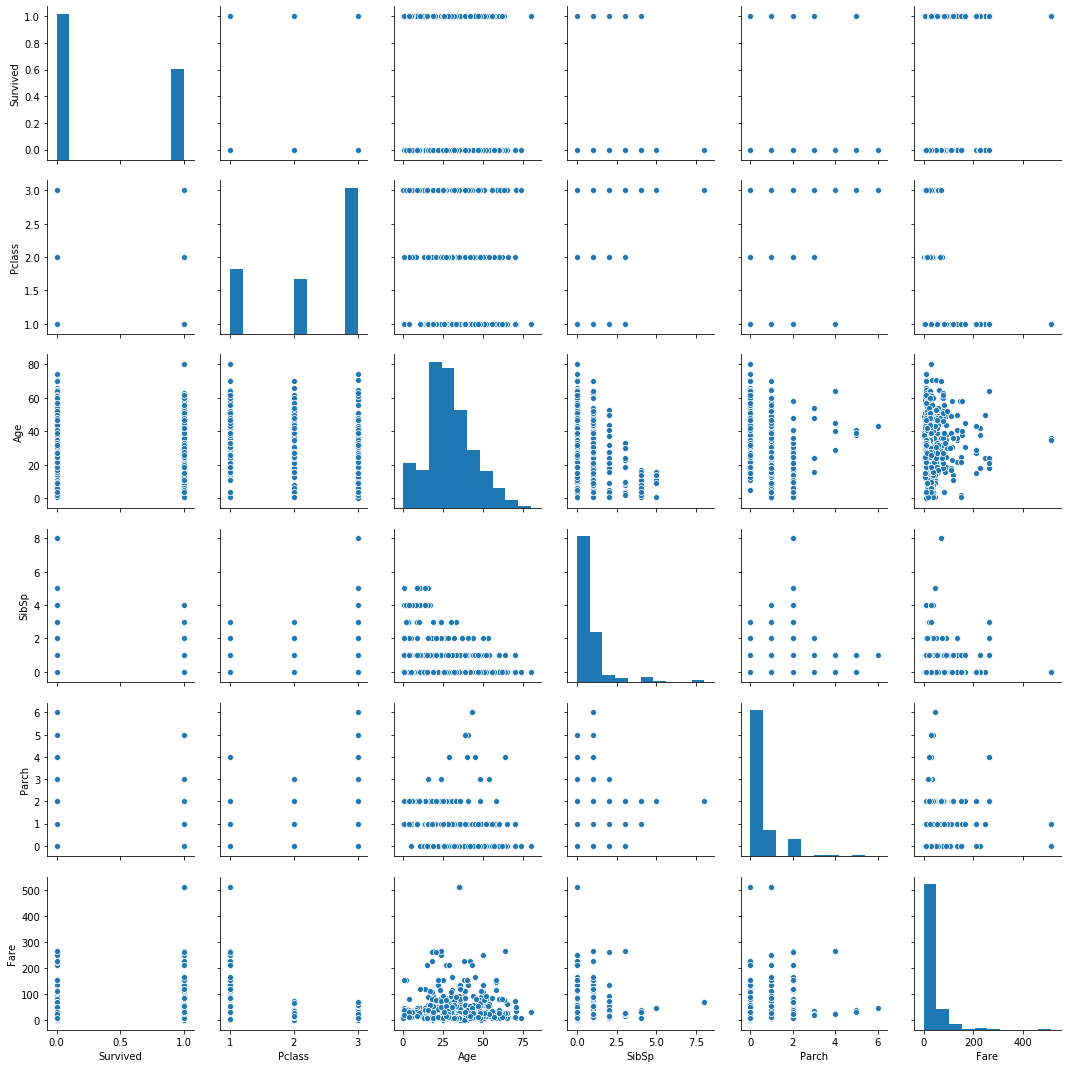

In [5]:
sns.pairplot(data=trainDf)

In [25]:
# Clean up NAs
# How many NAs?
NAs = pd.concat([trainDf.isnull().sum()], axis=1)
NAs[NAs.sum(axis=1) > 0]

# Fill missing Age value with mean
trainDf['Age'] = trainDf['Age'].fillna(trainDf['Age'].mean())
# Fill missing Embarked value with mode
trainDf['Embarked'] = trainDf['Embarked'].fillna(trainDf['Embarked'].mode()[0])
# Make Pclass into categorical strings to prevent partial estimates
trainDf['Pclass'] = trainDf['Pclass'].apply(str)

In [26]:
#Do the same to testDf
# How many NAs?
NAs = pd.concat([testDf.isnull().sum()], axis=1)
NAs[NAs.sum(axis=1) > 0]

# Fill missing Age value with mean
testDf['Age'] = testDf['Age'].fillna(testDf['Age'].mean())
# Fill missing Embarked value with mode
testDf['Embarked'] = testDf['Embarked'].fillna(testDf['Embarked'].mode()[0])
# Make Pclass into categorical strings to prevent partial estimates
testDf['Pclass'] = testDf['Pclass'].apply(str)

In [27]:
# Create Dummies for Train Data
trainNums = trainDf.drop(['Name','Survived','Ticket','Cabin', 'Pclass'], axis=1).select_dtypes('int64', 'float64')
trainCats = trainDf.drop(['Name', 'Survived','Ticket','Cabin'], axis=1).select_dtypes(exclude=['int64', 'float64'])
cat_feats = list(trainCats.columns.values.tolist())
dummyDf = pd.get_dummies(trainCats, columns = cat_feats, drop_first = True)
# Join dummyDf to trainDf
finalTrainDf = pd.concat([trainNums, dummyDf], axis=1, sort=False)
finalTrainDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 7 columns):
SibSp         891 non-null int64
Parch         891 non-null int64
Pclass_2      891 non-null uint8
Pclass_3      891 non-null uint8
Sex_male      891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
dtypes: int64(2), uint8(5)
memory usage: 65.2 KB


In [28]:
# Create Dummies for Test Data
testNums = testDf.drop(['Name','Ticket','Cabin','Pclass'], axis=1).select_dtypes('int64', 'float64')
testCats = testDf.drop(['Name','Ticket','Cabin'], axis=1).select_dtypes(exclude=['int64', 'float64'])
cat_feats = list(trainCats.columns.values.tolist())
dummyDf = pd.get_dummies(testCats, columns = cat_feats, drop_first = True)
# Join dummyDf to testDf
finalTestDf = pd.concat([testNums, dummyDf], axis=1, sort=False)
finalTestDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
SibSp         418 non-null int64
Parch         418 non-null int64
Pclass_2      418 non-null uint8
Pclass_3      418 non-null uint8
Sex_male      418 non-null uint8
Embarked_Q    418 non-null uint8
Embarked_S    418 non-null uint8
dtypes: int64(2), uint8(5)
memory usage: 11.8 KB


In [29]:
finalTrainDf.columns.difference(finalTestDf.columns)

Index([], dtype='object')

In [30]:
# Scale Data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(finalTrainDf)
scaled_features = scaler.transform(finalTrainDf)
scaledTrainDf = pd.DataFrame(scaled_features, columns = finalTrainDf.columns)

In [31]:
# Scale Test Data
scaler.fit(finalTestDf)
scaledTestfeatures = scaler.transform(finalTestDf)
scaledTestDf = pd.DataFrame(scaledTestfeatures, columns = finalTestDf.columns)

In [32]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaledTrainDf, trainDf['Survived'], test_size=0.3)

In [33]:
# Create Model
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [34]:
# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80       156
           1       0.74      0.62      0.67       112

    accuracy                           0.75       268
   macro avg       0.75      0.73      0.74       268
weighted avg       0.75      0.75      0.75       268



In [35]:
# Elbow Method on Neighbors K
error_rate= []
for i in range (1,40):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    pred_i = model.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

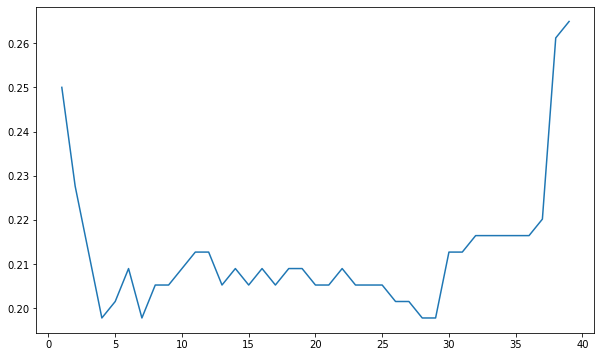

In [36]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate)

In [37]:
# Create Optimized Model, k=11
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train)
pred = model.predict(X_test)
# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       156
           1       0.85      0.64      0.73       112

    accuracy                           0.80       268
   macro avg       0.81      0.78      0.79       268
weighted avg       0.81      0.80      0.80       268

[[143  13]
 [ 40  72]]


In [38]:
# Try SVM
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)
# Evaluate
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       156
           1       0.83      0.67      0.74       112

    accuracy                           0.81       268
   macro avg       0.81      0.79      0.79       268
weighted avg       0.81      0.81      0.80       268

[[141  15]
 [ 37  75]]


/Users/garrickbercero/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [39]:
# SVM Grid Search
from sklearn.model_selection import GridSearchCV
param_grid= {'C':[0.1,1,10,100,1000], 'gamma':[1,0.1,0.01,0.001,0.0001]}
grid=GridSearchCV(SVC(), param_grid, verbose=3)
grid.fit(X_train, y_train)
grid.best_params_

/Users/garrickbercero/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ...................... C=0.1, gamma=1, score=0.808, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ...................... C=0.1, gamma=1, score=0.808, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ...................... C=0.1, gamma=1, score=0.802, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.788, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.764, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .................... C=0.1, gamma=0.1, score=0.768, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ...........

[CV] ................... C=1000, gamma=0.1, score=0.808, total=   0.0s
[CV] C=1000, gamma=0.1 ...............................................
[CV] ................... C=1000, gamma=0.1, score=0.773, total=   0.0s
[CV] C=1000, gamma=0.01 ..............................................
[CV] .................. C=1000, gamma=0.01, score=0.784, total=   0.0s
[CV] C=1000, gamma=0.01 ..............................................
[CV] .................. C=1000, gamma=0.01, score=0.817, total=   0.0s
[CV] C=1000, gamma=0.01 ..............................................
[CV] .................. C=1000, gamma=0.01, score=0.802, total=   0.0s
[CV] C=1000, gamma=0.001 .............................................
[CV] ................. C=1000, gamma=0.001, score=0.784, total=   0.0s
[CV] C=1000, gamma=0.001 .............................................
[CV] ................. C=1000, gamma=0.001, score=0.827, total=   0.0s
[CV] C=1000, gamma=0.001 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.9s finished


{'C': 0.1, 'gamma': 1}

In [43]:
# Try SVM, optimized
from sklearn.svm import SVC
model = SVC(C=0.1, gamma=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
# Evaluate
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.94      0.83       156
           1       0.86      0.56      0.68       112

    accuracy                           0.78       268
   macro avg       0.81      0.75      0.76       268
weighted avg       0.80      0.78      0.77       268

[[146  10]
 [ 49  63]]


In [44]:
finalTestDf.head()

,SibSp,Parch,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,
892,0,0,0,1,1,1,0
893,1,0,0,1,0,0,1
894,0,0,1,0,1,1,0
895,0,0,0,1,1,0,1
896,1,1,0,1,0,0,1


In [45]:
pred = model.predict(scaledTestDf)
presubmissionDf = pd.DataFrame(pred, columns=['Survived'])
presubmissionDf.index = np.arange(892, 892+len(presubmissionDf))
presubmissionDf = pd.concat([finalTestDf,presubmissionDf], axis=1)
presubmissionDf['Name']=testDf['Name']
presubmissionDf

,SibSp,Parch,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Survived,Name
892,0,0,0,1,1,1,0,0,"Kelly, Mr. James"
893,1,0,0,1,0,0,1,0,"Wilkes, Mrs. James (Ellen Needs)"
894,0,0,1,0,1,1,0,0,"Myles, Mr. Thomas Francis"
895,0,0,0,1,1,0,1,0,"Wirz, Mr. Albert"
896,1,1,0,1,0,0,1,1,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)"
...,...,...,...,...,...,...,...,...,...
1305,0,0,0,1,1,0,1,0,"Spector, Mr. Woolf"
1306,0,0,0,0,0,0,0,1,"Oliva y Ocana, Dona. Fermina"
1307,0,0,0,1,1,0,1,0,"Saether, Mr. Simon Sivertsen"
1308,0,0,0,1,1,0,1,0,"Ware, Mr. Frederick"


In [47]:
submissionDf=pd.DataFrame(presubmissionDf['Survived'], columns=['Survived'])
submissionDf = submissionDf.rename_axis('PassengerId')
submissionDf.to_csv('titanicSurvivorPredictions.csv')